$\textbf{Machine Intelligence Sheet 9:}$\
Belugas on the run


In [2]:
import numpy as np
import matplotlib.pyplot as plt


$\textbf{Exercise 2: Variability of Classification}$

Text(0, 0.5, 'Y')

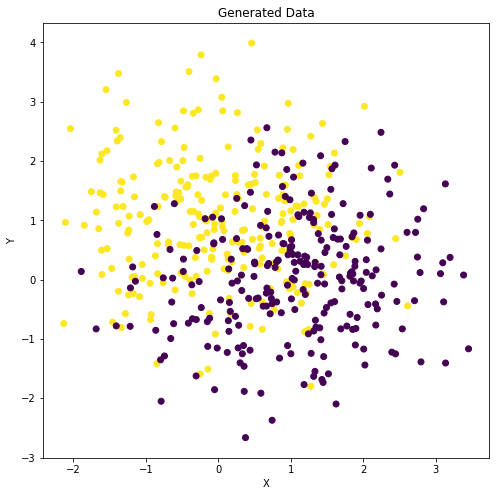

In [3]:
mean1 = np.eye(2)[:,1]
mean2 = np.eye(2)[:,0]

def generate_data (nsamples, mean1, mean2, cov1, cov2, y1, y2):
    
    """
    Generates a number of samples from multivariate normal
    distributions with different means. 
    
    @params:
    nsamples: the number of samples to be generated
    mean1: the mean of the first multivariate gaussian
    mean2: the mean of the second multivariate gaussian
    cov1: the covariance matrix of the first mg
    cov2: the covariances matrix of the second mg
    y1: the class label for the first sampled class 
    y2: the class label for the second sampled class
    """
    
    temp_num = int(nsamples / 2)
    
    zero = np.random.multivariate_normal(mean1, cov1, temp_num + nsamples % 2)
                                        
    one = np.random.multivariate_normal(mean2, cov2, temp_num)
    
    data0 = np.zeros((temp_num + nsamples % 2 ,3))
    data0[:,:2] = zero
    data0 [:,2] = np.ones(temp_num + nsamples % 2)
    
    data1 = np.zeros((temp_num, 3))
    data1[:,:2] = one
    data1[:,2] = np.ones(temp_num) * -1 
    

    return np.concatenate((data0, data1), axis=0)

generate_data_from_distribution = lambda nsamples: \
generate_data(nsamples, mean1, mean2, np.eye(2), np.eye(2), 1, -1)

X = generate_data_from_distribution(500)


#Plotting the data just for reference:

plt.figure(figsize = (8,8))

plt.scatter(X[:,0], X[:,1], c = X[:,2], cmap = 'viridis')
plt.title("Generated Data")
plt.xlabel('X')
plt.ylabel('Y')

In [3]:
def get_wghts (X):

    """
    Finds weights minimizing quadratic error
    @params:
    X: dataset for which weights are to be learned
    
    """

    Y = np.ones((X.shape[0], X.shape[1]))
    Y[:,1:3] = X[:,:2]
    
    return np.linalg.inv(Y.T @ Y) @ Y.T @ X[:,2]

def get_performance (model_params, ntests):
    
    """
    Gets the predictions for the classifier on unseen data
    @params:
    model_params: the model parameters – in this case weight
    matrix and bias
    ntests: the number of new points to show the model
    
    """
    
    bias = model_params[0]
    weights = model_params[1:3]
    
    test_data = generate_data_from_distribution(ntests)
    data_points = test_data[:,:2]
    target_values = test_data[:,2]
    
    prediction = np.sign(bias + data_points @ weights)
    
    return np.sum(np.equal(prediction, target_values)) / (2 *ntests)

print("The accuracy of the model is:", get_performance(get_wghts(X), 500)\
    * 100, "%") 

The accuracy of the model is: 38.0 %


The accuracy of the model is $\approx$ 75%. This is completely plausible given how our data are distributed. About half of each class is relatively easily classified (making for a total of 50% easy classification) as belonging to either of the two classes. But in the middlen there is a space where a linear model must essentially guess. Because there are exactly two classes, we should expect it to be right about half of the time. 

In [4]:
def mdl_results(nsamples, nreps = 50, ntests = 500):
    
    """
    Accumulates the accuracies of model on unseen data 
    over successive test runs
    @params:
    nsamples: data points in the original data
    nreps: number of repetitions
    ntests: number of unseen data shown on each iteration
    
    """
    
    accuracy_arr = np.zeros(nreps)
    
    params_arr = np.zeros((nreps, 3))
    
    i = 0
    
    while i < nreps:
    
        model_params = get_wghts(generate_data_from_distribution(nsamples))
    
        accuracy_arr[i] = get_performance(model_params, ntests)
        
        params_arr[i:,] = model_params
        
        i+= 1
    
    return accuracy_arr, params_arr

def plot_results(nreps = 50):    

    fig, axs = plt.subplots(1,2, sharex = True, figsize = (15,10))
    
    p = np.arange(3,101)
    p2 = np.array([3,4,6,8,10,20,40,100])
    
    means = np.vectorize(lambda x: np.mean(mdl_results(x)[0]))
    stds = np.vectorize(lambda x: np.std(mdl_results(x)[0]))
    wghts_mean = lambda x: np.mean(mdl_results(x)[1], axis = 0)
    wghts_std = lambda x: np.std(mdl_results(x)[1], axis = 0)
    
    ms, ms2 = means(p), means(p2)
    sd, sd2 = stds(p), stds(p2)
    ws = np.array(list(map(wghts_mean, p)))
    wsds = np.array(list(map(wghts_std, p)))
   
   
    axs[0].errorbar(p, ms, yerr = sd, marker='.', mfc='red',ms=4, mew=2)
    axs[0].set_title('Mean Error and Standard deviation of model accuracy')
    axs[0].set_xlabel('Number of Training Samples')
    axs[0].set_ylabel('Mean and Standard Deviation')
    
    axs[1].errorbar(p, ws[:,0], yerr = wsds[:,0], label = r'$\theta$ = $w_0$')
    axs[1].errorbar(p, ws[:,1], yerr = wsds[:,1], label = '$w_1$')
    axs[1].errorbar(p, ws[:,2], yerr = wsds[:,2], label = '$w_2$')
    axs[1].set_title('Means and Standard Deviation of Weights')
    axs[1].set_xlabel('p')
    axs[1].set_ylabel('Mean and Standard deviation')
    axs[1].legend()  

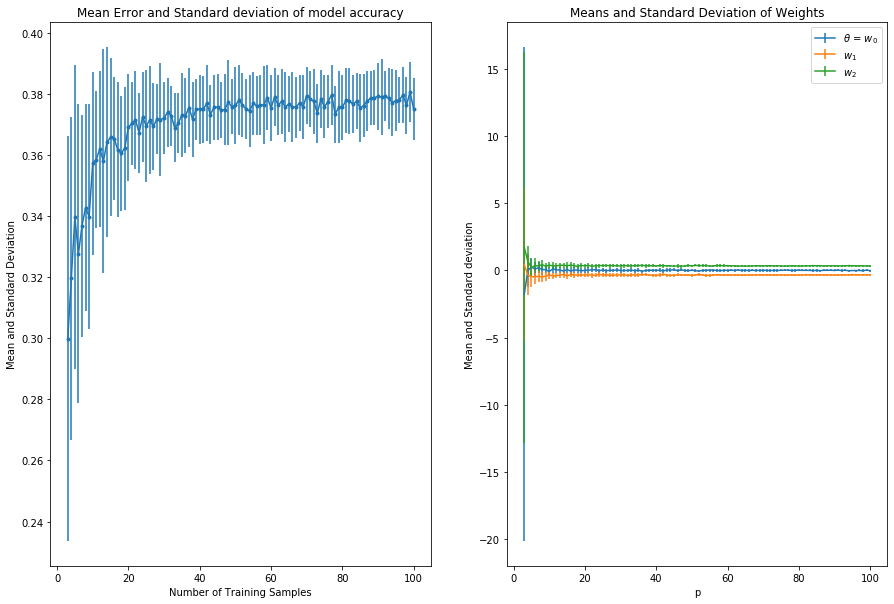

In [5]:
plot_results()

$\textbf{Answer:}$ For both the model parameters and the model accuracy, adding data points decreases the variance in the produced ouputs. The mean of the model accuracy is also increased as we increase the number of samples. 


$\textbf{Exercise 3: the Binomial distribution:}$

In [6]:
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson

In [45]:
def plot_binomial():
    
    fig, axs = plt.subplots(3, 9, sharey = True, sharex = False, \
                           figsize = (20,10))
    
    #Counter variables for plotting:
    
    i = 0
    j = 0
    
    for nI, n in np.ndenumerate(np.array([25,50,100])):
        
        for pI, p in np.ndenumerate(np.arange(.1,1,.1)):
            
            x = np.arange(binom.ppf(.01, n, p),\
                         binom.ppf(.99, n, p))
            
            axs[i,j].bar(x, binom.pmf(x,n, p), \
                         label = ' n = {}, p = {}'. format(n, p),\
                         color = 'C{}'.format(i)\
                        )
            axs[i,j].set_xlabel('k')
            axs[0,j].set_title('p = {}'. format(round(p, 2)))
            axs[i,0].set_ylabel('Probability, (n = {})'.format(n))
        
           
            
            if j % 8 == 0 and j != 0:
                
                i += 1
                j = 0
                
            else:
                
                j += 1
                
            #plt.tight_layout()
                


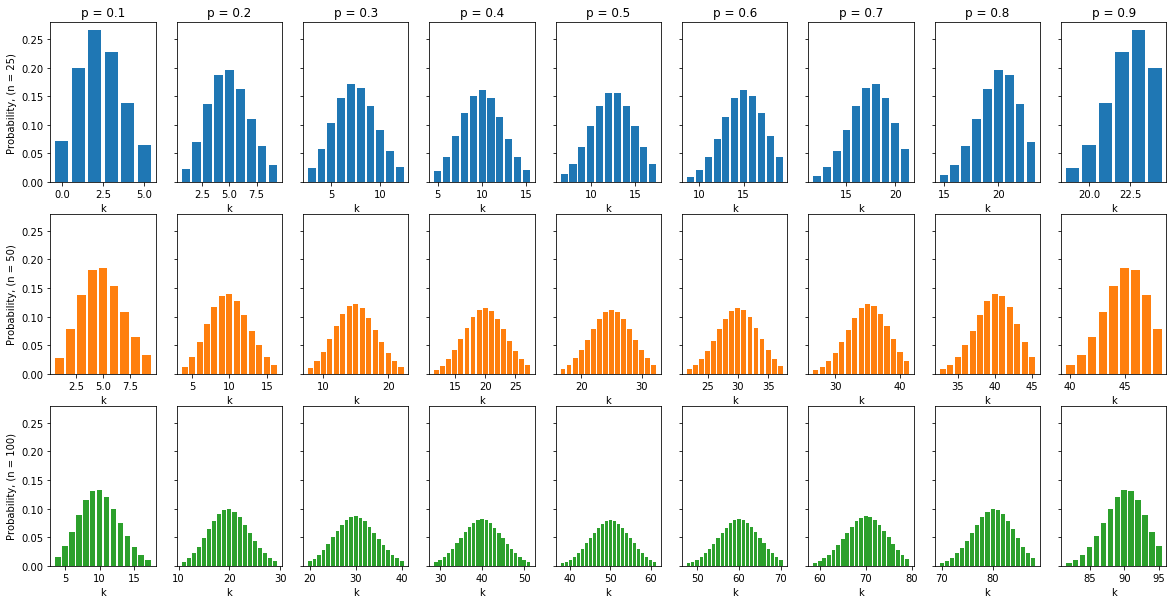

In [46]:
plot_binomial()

$\textbf{Answer:}$ The assumption is reasonable for large $n$. This fact follows from the the central limit theorem.  From this theorem we can also estimate the average error that follows from approximating a binomial distribution by a Gaussian with mean $np$ and variance $np(1 - p)$ as $\frac{1}{\sqrt{n}}$. Therefore if we have very small sample-sizes we will  sometimes find that the Gaussian distribution is very bad for approximating a binomial one (of course, the normal distribution will also give us a bad approximation if we choose the wrong moments, but that is trivial).

$\textbf{Answer:}$ The Poisson is a good approximation of the binomial distribution under the following conditions: Let $X_1$ and $X_1$ be Pois($\lambda_1$) and Pois($\lambda_2$) distributed  random variables; then $X_1 | X_1 + X_2$ is an approximately binomially distributed random variable, if $X_1$ and $X_2$ are independent. Generally, if $n \rightarrow \infty$ and $p \rightarrow 0$ and $np \rightarrow \lambda$, then a binomial distribution can be modelled by a Poisson distribution.

$\textbf{Answer:}$ The following four plots consider cases in which Poisson and Gaussian distributions are good approximations of the binomial distribution and bad ones respecctively.

In [55]:
def plot_results():

    fig, axs = plt.subplots(2,2, sharex = False, sharey = False, \
                        figsize = (20,20))

    param_arr = np.array([(20,.5), (3, .3), (20, .5), (20, .05)])
    i = 0 
    j = 0
    
    for n, p in param_arr:
    
        x = np.arange(binom.ppf(.01, n, p), binom.ppf(.99, n, p))
    
        axs[i,j].bar(x, binom.pmf(x, n, p))
        axs[i,j].set_xlabel('x')
        axs[i,j].set_ylabel('P[X = x]')
        
        if i == 0: 
            
            axs[i,j].plot(x, norm.pdf(x, n * p, np.sqrt(n * p * (1 - p))),\
                         linewidth = 10, c = 'r')
            axs[i,j].set_title('Normal distribution, mean = {}, stdv = {}'\
                               .format(round(n * p,2), round(np.sqrt(n * p * (1 - p)), 2)))
            
        else: 
            
            axs[i,j].plot(x, poisson.pmf(x, n * p),\
                         linewidth = 20, c = 'r')
            axs[i,j].set_title('Poisson distribution, $\lambda$ = {}'\
                              .format(round(n * p, 2)))


            
        if j == 1:
                
            i+= 1
            j = 0
            
        else:
                
            j+= 1


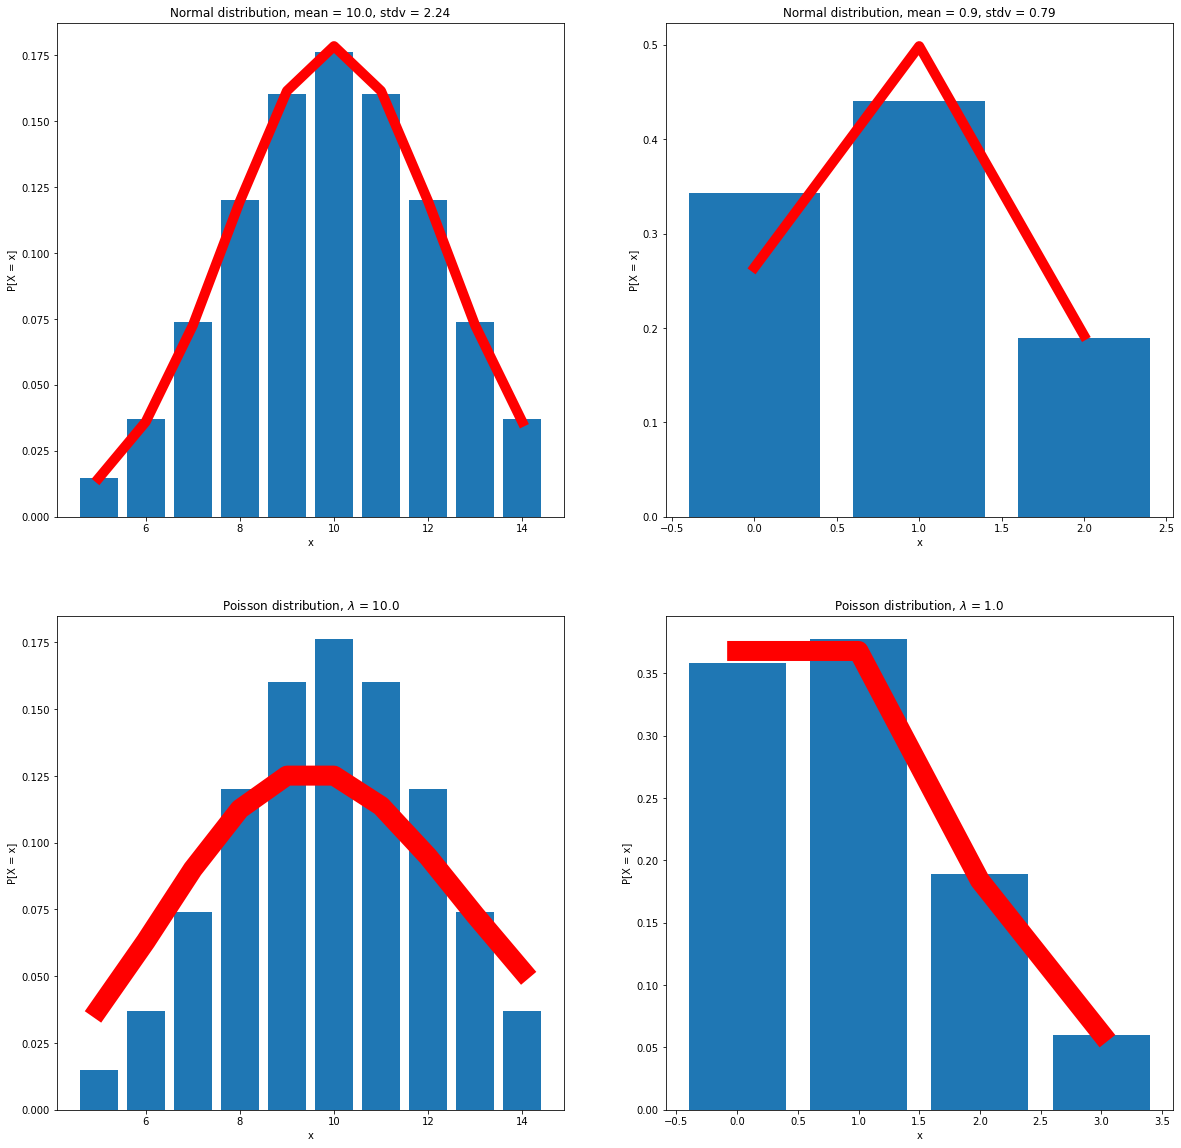

In [56]:
plot_results()

$\textbf{Answer:}$ To the left hand side, we see good approximations of the binomial distribution by both the normal and the Poisson distributions respectively. On the right hand side, we see the opposite. In case of the normal distribution, the poorness of the approximation is due solely to the fact that we are using a small $n$. In the case of the Poisson distribution it is beacause we are using too large a $p$.

In [15]:
import collections

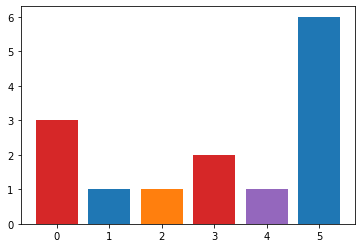

In [27]:
a = np.array([1,2,3,3,4,5,5,5,5,5,5,0,0,0])

for ax in a:

    plt.bar(ax, collections.Counter(a)[ax])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

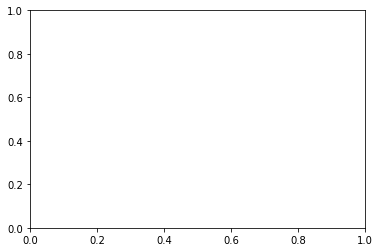

<BarContainer object of 24 artists>

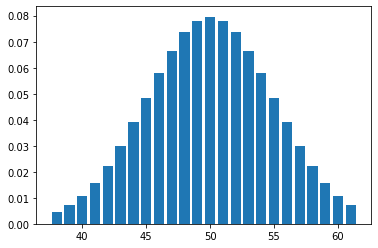

In [32]:
n = 100
p = .5

x = np.arange(binom.ppf(.01, 100, .5),\
                         binom.ppf(.99, 100, .5))

plt.bar(x, binom.pmf(x,n, p))
                         

